In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
data = pd.read_csv('gini_income_crime_avs.csv')

In [3]:
data.head()

,State,mean_gini,mean_medians,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_white_poverty,share_non_white,share_voters_voted_trump,share_hate_crimes_per_pop
0,Alabama,0.47534,57249.0,0.060,0.64,0.821,0.12,0.35,0.63,0.000007
1,Alaska,0.41648,85900.6,0.064,0.63,0.914,0.06,0.42,0.53,0.000010
2,Arizona,0.46444,61933.6,0.063,0.90,0.842,0.09,0.49,0.50,0.000034
3,Arkansas,0.46898,53459.4,0.052,0.69,0.824,0.12,0.26,0.60,0.000004
4,California,0.48464,74437.2,0.059,0.97,0.806,0.09,0.61,0.33,0.000024


# Prep for VIF/OLS

In [30]:
outcome = 'share_hate_crimes_per_pop'
x_cols = ['mean_gini', 'mean_medians', 'share_unemployed_seasonal', 'share_population_with_high_school_degree','share_white_poverty', 'share_non_white', 'share_voters_voted_trump']

In [31]:
#preprocessing
data.columns = [col.replace(' ', '_') for col in data.columns]
for col in x_cols:
    data[col] = (data[col] - data[col].mean())/data[col].std()
data

,State,mean_gini,mean_medians,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_white_poverty,share_non_white,share_voters_voted_trump,share_hate_crimes_per_pop
0,Alabama,0.649385,-1.145759,0.975064,0.64,-1.412183,1.142443,0.208069,1.179347e+00,0.000007
1,Alaska,-2.126930,1.444590,1.348961,0.63,1.317232,-1.285248,0.632530,3.369564e-01,0.000010
2,Arizona,0.135252,-0.722231,1.255487,0.90,-0.795863,-0.071403,1.056990,8.423909e-02,0.000034
3,Arkansas,0.349395,-1.488371,0.227271,0.69,-1.324137,1.142443,-0.337666,9.266300e-01,0.000004
4,California,1.088048,0.408201,0.881590,0.97,-1.852411,-0.071403,1.784637,-1.347825e+00,0.000024
5,Colorado,-0.146813,0.757630,-0.894420,0.80,0.700912,-0.880633,-0.034480,-4.211955e-01,0.000020
6,Connecticut,1.454073,1.889147,0.227271,0.94,0.495472,-1.285248,-0.095117,-6.739127e-01,0.000032
7,Delaware,-0.675096,0.337068,-0.053152,0.90,0.143290,-0.476018,0.329343,-5.896737e-01,0.000017
8,District of Columbia,3.287025,1.929180,1.629384,1.00,0.055244,-2.094478,1.905911,-3.790759e+00,0.000177
9,Florida,1.007862,-0.940133,0.227271,0.96,-0.473029,0.737828,0.875078,-7.484345e-17,0.000008


In [32]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

#problems: r2 low

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     share_hate_crimes_per_pop   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.448
Method:                        Least Squares   F-statistic:                     6.682
Date:                       Fri, 17 Jan 2020   Prob (F-statistic):           2.47e-05
Time:                               09:48:38   Log-Likelihood:                 476.00
No. Observations:                         50   AIC:                            -936.0
Df Residuals:                             42   BIC:                            -920.7
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 2.354e-05   2.77e-06      8.495      0.000    1.79e-05    2.91e-05
mean_gini                                 1.547e-05   4.65e-06      3.330      0.002     6.1e-06    2.48e-05
mean_medians                              1.804e-06   5.37e-06      0.336      0.738   -9.03e-06    1.26e-05
share_unemployed_seasonal                 3.806e-06   3.99e-06      0.955      0.345   -4.24e-06    1.18e-05
share_population_with_high_school_degree  1.213e-05   6.75e-06      1.796      0.080    -1.5e-06    2.58e-05
share_white_poverty                       4.212e-06   5.14e-06      0.820      0.417   -6.15e-06    1.46e-05
share_non_white                          -3.868e-06   5.85e-06     -0.661      0.512   -1.57e-05    7.94e-06
share_voters_voted_trump                 -9.679e-06   4.75e-06     -2.039      0.048   -1.93e-05      -1e-07
==============================================================================
Omnibus:                       19.827   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.492
Skew:                           1.114   Prob(JB):                     4.38e-09
Kurtosis:                       6.676   Cond. No.                         5.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
X = data[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('mean_gini', 1.6798656972105863),
 ('mean_medians', 3.363877799007723),
 ('share_unemployed_seasonal', 1.7096768688113273),
 ('share_white_poverty', 2.8220884164462867),
 ('share_non_white', 1.7460723785916452),
 ('share_voters_voted_trump', 2.6086962233940003)]

In [33]:
#remove variables with low p values
outcome = 'share_hate_crimes_per_pop'
x_cols = ['mean_gini', 'share_voters_voted_trump']
#'mean_medians', 'share_unemployed_seasonal', 'share_white_poverty', 'share_non_white', 

In [34]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     share_hate_crimes_per_pop   R-squared:                       0.406
Model:                                   OLS   Adj. R-squared:                  0.381
Method:                        Least Squares   F-statistic:                     16.08
Date:                       Fri, 17 Jan 2020   Prob (F-statistic):           4.78e-06
Time:                               10:07:36   Log-Likelihood:                 470.32
No. Observations:                         50   AIC:                            -934.6
Df Residuals:                             47   BIC:                            -928.9
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 2.398e-05   2.91e-06      8.254      0.000    1.81e-05    2.98e-05
mean_gini                 6.847e-06   3.24e-06      2.113      0.040    3.28e-07    1.34e-05
share_voters_voted_trump -1.282e-05   3.27e-06     -3.917      0.000   -1.94e-05   -6.24e-06
==============================================================================
Omnibus:                       23.702   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.001
Skew:                           1.363   Prob(JB):                     6.22e-11
Kurtosis:                       6.890   Cond. No.                         1.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

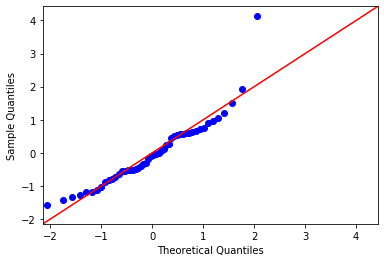

In [45]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
#some violations to the model but overall an okay fit

ValueError: x and y must be the same size

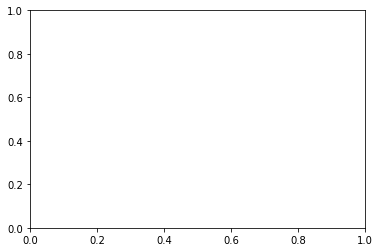

In [11]:
plt.scatter(model.predict(data[x_cols]), model.resid)
plt.plot(model.predict(data[x_cols]), [0 for i in range(len(data))])

#outliers displaying disproportionate errors, consider removing outliers (how do we identify outliers)

In [ ]:
#remove outliers

# Train test split

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('gini_income_crime_avs1.csv')
data.head()

,State,mean_gini,mean_medians,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_white_poverty,share_non_white,share_voters_voted_trump,share_hate_crimes_per_pop
0,Alabama,0.47534,57249.0,0.060,0.64,0.821,0.12,0.35,0.63,0.000007
1,Alaska,0.41648,85900.6,0.064,0.63,0.914,0.06,0.42,0.53,0.000010
2,Arizona,0.46444,61933.6,0.063,0.90,0.842,0.09,0.49,0.50,0.000034
3,Arkansas,0.46898,53459.4,0.052,0.69,0.824,0.12,0.26,0.60,0.000004
4,California,0.48464,74437.2,0.059,0.97,0.806,0.09,0.61,0.33,0.000024


In [62]:
data.dtypes

State                                        object
mean_gini                                   float64
mean_medians                                float64
share_unemployed_seasonal                   float64
share_population_in_metro_areas             float64
share_population_with_high_school_degree    float64
share_white_poverty                         float64
share_non_white                             float64
share_voters_voted_trump                    float64
share_hate_crimes_per_pop                   float64
dtype: object

In [93]:
data2 = data.drop(['State'], axis = 1)

In [94]:
data2 #do i run sklearn.preprocessing on this dataset? yes

,mean_gini,mean_medians,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_white_poverty,share_non_white,share_voters_voted_trump,share_hate_crimes_per_pop
0,0.47534,57249.0,0.060,0.64,0.821,0.12,0.35,0.63,0.000007
1,0.41648,85900.6,0.064,0.63,0.914,0.06,0.42,0.53,0.000010
2,0.46444,61933.6,0.063,0.90,0.842,0.09,0.49,0.50,0.000034
3,0.46898,53459.4,0.052,0.69,0.824,0.12,0.26,0.60,0.000004
4,0.48464,74437.2,0.059,0.97,0.806,0.09,0.61,0.33,0.000024
5,0.45846,78302.2,0.040,0.80,0.893,0.07,0.31,0.44,0.000020
6,0.49240,90817.8,0.052,0.94,0.886,0.06,0.30,0.41,0.000032
7,0.44726,73650.4,0.049,0.90,0.874,0.08,0.37,0.42,0.000017
8,0.53126,91260.6,0.067,1.00,0.871,0.04,0.63,0.04,0.000177
9,0.48294,59523.4,0.052,0.96,0.853,0.11,0.46,0.49,0.000008


In [50]:
# z_score_df = pd.DataFrame(z_score, columns= ['mean_gini', 'mean_medians', 'share_unemployed_seasonal', 'share_population_in_metro_areas', 'share_population_with_high_school_degree', 'share_white_poverty', 'share_non_white', 'share_voters_voted_trump', 'share_hate_crimes_per_pop'])
# z_score_df
# or on standardized zscore
#this seems strange

In [82]:
#data2.drop([8])

,mean_gini,mean_medians,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_white_poverty,share_non_white,share_voters_voted_trump,share_hate_crimes_per_pop
0,0.47534,57249.0,0.060,0.64,0.821,0.12,0.35,0.63,0.000007
1,0.41648,85900.6,0.064,0.63,0.914,0.06,0.42,0.53,0.000010
2,0.46444,61933.6,0.063,0.90,0.842,0.09,0.49,0.50,0.000034
3,0.46898,53459.4,0.052,0.69,0.824,0.12,0.26,0.60,0.000004
4,0.48464,74437.2,0.059,0.97,0.806,0.09,0.61,0.33,0.000024
5,0.45846,78302.2,0.040,0.80,0.893,0.07,0.31,0.44,0.000020
6,0.49240,90817.8,0.052,0.94,0.886,0.06,0.30,0.41,0.000032
7,0.44726,73650.4,0.049,0.90,0.874,0.08,0.37,0.42,0.000017
9,0.48294,59523.4,0.052,0.96,0.853,0.11,0.46,0.49,0.000008
10,0.47924,62118.8,0.058,0.82,0.839,0.09,0.48,0.51,0.000005


In [95]:
#separate target variable and predictor, split into training and test sets

y = data[['share_hate_crimes_per_pop']]
X = data[['mean_gini', 'mean_medians', 'share_unemployed_seasonal', 'share_population_in_metro_areas', 'share_population_with_high_school_degree', 'share_white_poverty', 'share_non_white', 'share_voters_voted_trump', 'share_hate_crimes_per_pop']]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [97]:
len(X_train)

25

In [98]:
len(data2)

51

In [99]:
len(y_train)

25

In [100]:
len(y_test)

26

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [102]:
len(y_train)

35

In [103]:
len(X_train)

35

In [104]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_train, y_test))

ValueError: Found input variables with inconsistent numbers of samples: [35, 16]

In [22]:
# from sklearn import linear_model
# reg= linear_model.LinearRegression()
# reg.fit(X_train, y_train)
# LinearRegression()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Polynomial Regression

In [105]:
#this went poorly
from sklearn.preprocessing import PolynomialFeatures

y = y_train['share_hate_crimes_per_pop']
X = X_train['mean_gini', 'mean_medians','share_voters_voted_trump']

poly = PolynomialFeatures(2)
X_fin = poly.fit_transform(X)

KeyError: ('mean_gini', 'mean_medians', 'share_voters_voted_trump')

In [108]:
print('The transformed feature names are: {}'.format(poly.get_feature_names()))
print('------------------')
print('The first row of transformed data is: {}'.format(X_fin[0]))

The transformed feature names are: ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x5^2', 'x5 x6', 'x5 x7', 'x6^2', 'x6 x7', 'x7^2']
------------------
The first row of transformed data is: [ 1.          0.64938464 -1.14575857  0.97506414  0.64        0.821
  1.14244273  0.20806892  1.1793473   0.42170041 -0.74403801  0.63319167
  0.41560617  0.53314479  0.74188475  0.13511676  0.76585002  1.31276271
 -1.1171881  -0.73328549 -0.94066779 -1.30896355 -0.23839675 -1.35124728
  0.95075008  0.62404105  0.80052766  1.11395494  0.20288054  1.14993927
  0.4096      0.52544     0.73116334  0.13316411  0.75478227  0.674041
  0.93794548  0.17082458  0.96824414  1.30517538  0.23770683  1.34733675
  0.04329268  0.24538552  1.390860

In [109]:
reg_poly = LinearRegression().fit(X_fin, y)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Ridge/Lasso Regression

In [106]:
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)
# X_train_transformed = scale.fit_transform(X_train)
# X_test_transformed = scale.transform(X_test)

In [107]:
# Build a Ridge, Lasso and regular linear regression model  
# Note that in scikit-learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_transformed, y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train_transformed, y_train)

lin = LinearRegression()
lin.fit(X_train_transformed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [108]:
# Generate preditions for training and test sets
y_h_ridge_train = ridge.predict(X_train_transformed)
y_h_ridge_test = ridge.predict(X_test_transformed)

y_h_lasso_train = np.reshape(lasso.predict(X_train_transformed), (35, 1))
y_h_lasso_test = np.reshape(lasso.predict(X_test_transformed), (16, 1))

y_h_lin_train = lin.predict(X_train_transformed)
y_h_lin_test = lin.predict(X_test_transformed)

In [109]:
print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train)**2))
print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train_transformed))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test_transformed))**2))

Train Error Ridge Model share_hate_crimes_per_pop    2.880014e-09
dtype: float64
Test Error Ridge Model share_hate_crimes_per_pop    1.325702e-09
dtype: float64


Train Error Lasso Model share_hate_crimes_per_pop    3.031821e-08
dtype: float64
Test Error Lasso Model share_hate_crimes_per_pop    3.952532e-09
dtype: float64


Train Error Unpenalized Linear Model share_hate_crimes_per_pop    3.380282e-38
dtype: float64
Test Error Unpenalized Linear Model share_hate_crimes_per_pop    1.237645e-38
dtype: float64


In [79]:
print('Ridge parameter coefficients:', ridge.coef_)
print('Lasso parameter coefficients:', lasso.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [[ 2.83738299e-05  5.79717749e-06  2.27657341e-06 -4.70572670e-06
   9.91621767e-06  3.40047417e-06  3.02613458e-07 -2.45805363e-05
   9.02620250e-05]]
Lasso parameter coefficients: [ 0.  0.  0.  0.  0. -0.  0. -0.  0.]
Linear model parameter coefficients: [[-9.75589590e-20  8.30964622e-20  1.70673848e-20  1.04502729e-20
   1.56314922e-20  2.21339508e-20  1.88875726e-20  1.92746085e-20
   1.73861433e-04]]
